In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

In [2]:
df_all = pd.read_csv('fanfic_regression_data_curated.tsv', sep = '\t')

In [3]:
len(df_all)

698002

In [4]:
df_all['ChapterIndex'].fillna(0, inplace=True)

In [5]:
df_all['Term_novelty'].head()

0    0.888159
1    0.353749
2    0.855796
3    0.706213
4    0.732386
Name: Term_novelty, dtype: float64

### Logistic

In [6]:
def run_logit(df, field):
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna(how = 'any')
    df['Intercept'] = 1.0
    df['binary'] = df[field].apply(lambda x: 1 if x != 0.0 else 0)
    logit_model = sm.Logit(df['binary'], df[['Chapters',\
        'Term_novelty', 'Topic_novelty',\
        'Freq_relationship', 'Category_F_M',\
       'Category_Gen', 'Category_M_M', 'Category_Multi', 'Category_Other','Category_Unknown', \
       'ArchiveWarnings_underage', 'ArchiveWarnings_death',\
       'ArchiveWarnings_choose_no', 'ArchiveWarnings_no_apply',\
       'ArchiveWarnings_violence',\
       'ArchiveWarnings_noncon', 'author_fic_cnt', 'Rating_G',\
       'Rating_M', 'Rating_N', 'Rating_T',\
       'Fandom_dcu', 'Fandom_doctor_who', 'Fandom_star_wars',
       'Fandom_arthurian', 'Fandom_supernatural', 'Fandom_haikyuu',
       'Fandom_kuroko_no_basuke', 'Fandom_hamilton_miranda',
       'Fandom_dragon_age', 'Fandom_the_walking_dead', 'Fandom_buffy',
       'Fandom_les_miserables', 'Fandom_naruto', 'Fandom_tolkien',
       'Fandom_shakespare', 'Fandom_hetalia', 'Fandom_attack_on_titan',
       'Fandom_ms_paint_adventures', 'Fandom_homestuck', 'Fandom_marvel',
       'Fandom_sailor_moon', 'Fandom_one_direction', 'Fandom_sherlock',
       'History', 'Intercept']]).fit(method='bfgs')
    pred = logit_model.predict()
    df['nonzero_prob'] = pred
    return df

### OLS

In [7]:
def run_ols(df, field):
    df = run_logit(df, field)
    df['Kudos'] = np.log(df['Kudos']+0.001)
    df['Hits'] = np.log(df['Hits']+0.001)
    df['Comments'] = np.log(df['Comments']+1)
    df['Bookmarks'] = np.log(df['Bookmarks']+0.001)
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna(how = 'any')
    model = ols( field + " ~ Term_novelty + Topic_novelty\
 + Chapters + Freq_relationship + author_fic_cnt + History\
 + Category_Gen + Category_F_M + Category_M_M + Category_Multi + Category_Other + Category_Unknown \
 + ArchiveWarnings_underage + ArchiveWarnings_death + ArchiveWarnings_violence +\
 ArchiveWarnings_noncon + ArchiveWarnings_choose_no +\
 ArchiveWarnings_no_apply + Rating_N + Rating_E + Rating_M + Rating_T\
 + Fandom_dcu + Fandom_doctor_who + Fandom_star_wars + Fandom_arthurian + \
 Fandom_supernatural + Fandom_haikyuu + Fandom_kuroko_no_basuke + Fandom_hamilton_miranda\
 + Fandom_dragon_age + Fandom_the_walking_dead + Fandom_buffy + Fandom_les_miserables \
 + Fandom_naruto + Fandom_tolkien + Fandom_shakespare + Fandom_hetalia + \
 Fandom_attack_on_titan + Fandom_ms_paint_adventures + Fandom_homestuck +\
 Fandom_marvel + Fandom_sailor_moon + Fandom_one_direction + Fandom_sherlock \
 + nonzero_prob", data = df).fit()
    return model

### Plot coefficients

In [8]:
kudos_model = run_ols(df_all, 'Kudos')
kudos_coef = np.asarray(list(kudos_model.params)[1:-1])
kudos_err = list(kudos_model.bse)[1:-1]

/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1674: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1674: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1674: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:

         Current function value: 0.077132
         Iterations: 35
         Function evaluations: 97
         Gradient evaluations: 86


/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [9]:
ylabels =['Term novelty', 'Topic novelty', 'Chapters', \
 'Frequent relationship',' Author work count','Age',\
 'Category (Gen)','Category (F/M)',' Category (M/M) ',' Category (Multi)','Category (Other)','Category (Unknown)\
 ','ArchiveWarnings (underage)','ArchiveWarnings (death)',' ArchiveWarnings (violence)','\
 ArchiveWarnings (non-consensual)','ArchiveWarnings (choose not to use)','\
 ArchiveWarnings (no warinigs apply)','Rating (Not rated)', 'Rating (Explicit)','Rating (Mature)',' Rating (Teens)\
 ',' Fandom (DCU) ',' Fandom (Doctor Who) ',' Fandom (Star Wars) ',' Fandom (Arthurian Mythologies)',\
  'Fandom (Supernatural)','Fandom (Haikyuu)',' Fandom (Kuroko no Basuke)',' Fandom (Hamilton/Miranda)\
 ',' Fandom (Dragon Age)',' Fandom (The Walking Dead)',' Fandom (Buffy the Vampire Slayer)','Fandom (Les Miserables)\
 ',' Fandom (Naruto)','Fandom (Tolkien)',' Fandom (Shakespare)','Fandom (Axis Powers Hetalia)',' \
 Fandom (Attack on Titan)',' Fandom (Ms Paint Adventures)',' Fandom (Homestuck)','\
Fandom (Marvel)',' Fandom (Sailor Moon)',' Fandom (One Direction)','Fandom (Sherlock)'][::-1]

In [10]:
hits_model = run_ols(df_all, 'Hits')
hits_coef = list(hits_model.params)[1:-1]
hits_err = list(hits_model.bse)[1:-1]

/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1674: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1674: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1674: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:

         Current function value: 0.090618
         Iterations: 35
         Function evaluations: 63
         Gradient evaluations: 55


/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [11]:
comments_model = run_ols(df_all, 'Comments')
comments_coef = list(comments_model.params)[1:-1]
comments_err = list(comments_model.bse)[1:-1]

/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1674: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1674: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 16
         Gradient evaluations: 4


/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [12]:
bookmarks_model = run_ols(df_all, 'Bookmarks')
bookmarks_coef = list(bookmarks_model.params)[1:-1]
bookmarks_err = list(bookmarks_model.bse)[1:-1]

/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1674: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1674: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: 0.423554
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 43


/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


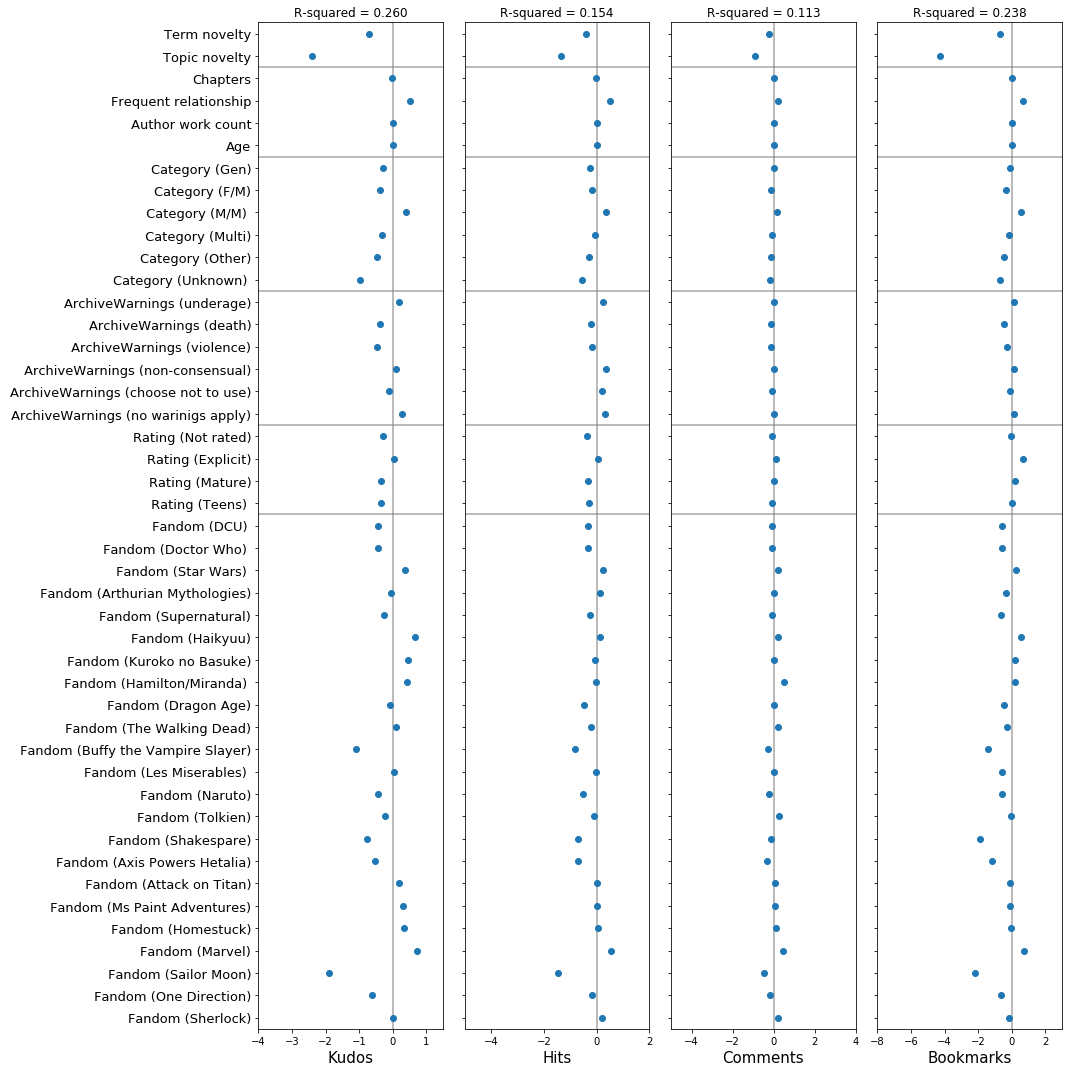

In [13]:
fig, ax = plt.subplots(1,4,figsize = (15,15))
ax[0].errorbar(kudos_coef[::-1], range(len(kudos_coef)), xerr=kudos_err[::-1] , fmt='o')
ax[0].set_yticks(range(len(kudos_coef)))
ax[0].set_yticklabels(ylabels)
ax[0].plot([0 for i in range(len(kudos_coef)+2)], range(-1,len(kudos_coef)+1), c='grey', alpha = 0.7)
ax[0].plot(range(-8,3), [22.5 for i in range(-8,3)] ,c='grey', alpha = 0.7)
ax[0].plot(range(-8,3), [26.5 for i in range(-8,3)] ,c='grey', alpha = 0.7)
ax[0].plot(range(-8,3), [32.5 for i in range(-8,3)] ,c='grey', alpha = 0.7)
ax[0].plot(range(-8,3), [38.5 for i in range(-8,3)] ,c='grey', alpha = 0.7)
ax[0].plot(range(-8,3), [42.5 for i in range(-8,3)] ,c='grey', alpha = 0.7)
ax[0].set_ylim(-0.5,44.5)
ax[0].set_xlim(-4,1.5)
ax[0].set_xlabel('Kudos', fontsize=15)
ax[0].set_title('R-squared = 0.260')
for tick in ax[0].yaxis.get_major_ticks():
    tick.label.set_fontsize(13)

ax[1].errorbar(hits_coef[::-1], range(len(hits_err)), xerr=hits_err[::-1], fmt='o')
ax[1].set_yticks(range(len(hits_coef)))
# ax[1].set_yticklabels(ylabels)
ax[1].plot([0 for i in range(len(hits_coef)+2)], range(-1,len(hits_coef)+1), c='grey', alpha = 0.7)
ax[1].plot(range(-8,3), [22.5 for i in range(-8,3)] ,c='grey', alpha = 0.7)
ax[1].plot(range(-8,3), [26.5 for i in range(-8,3)] ,c='grey', alpha = 0.7)
ax[1].plot(range(-8,3), [32.5 for i in range(-8,3)] ,c='grey', alpha = 0.7)
ax[1].plot(range(-8,3), [38.5 for i in range(-8,3)] ,c='grey', alpha = 0.7)
ax[1].plot(range(-8,3), [42.5 for i in range(-8,3)] ,c='grey', alpha = 0.7)
ax[1].set_ylim(-0.5,44.5)
ax[1].set_xlim(-5,2)
ax[1].set_yticklabels([])
ax[1].set_title('R-squared = 0.154')
ax[1].set_xlabel('Hits', fontsize=15)

ax[2].errorbar(comments_coef[::-1], range(len(comments_err)), xerr=comments_err[::-1], fmt='o')
ax[2].set_yticks(range(len(comments_coef)))
ax[2].plot([0 for i in range(len(comments_coef)+2)], range(-1,len(comments_coef)+1), c='grey', alpha = 0.7)
ax[2].plot(range(-8,5), [22.5 for i in range(-8,5)] ,c='grey', alpha = 0.7)
ax[2].plot(range(-8,5), [26.5 for i in range(-8,5)] ,c='grey', alpha = 0.7)
ax[2].plot(range(-8,5), [32.5 for i in range(-8,5)] ,c='grey', alpha = 0.7)
ax[2].plot(range(-8,5), [38.5 for i in range(-8,5)] ,c='grey', alpha = 0.7)
ax[2].plot(range(-8,5), [42.5 for i in range(-8,5)] ,c='grey', alpha = 0.7)
ax[2].set_ylim(-0.5,44.5)
ax[2].set_xlim(-5,4)
ax[2].set_yticklabels([])
ax[2].set_title('R-squared = 0.113')
ax[2].set_xlabel('Comments', fontsize=15)


ax[3].errorbar(bookmarks_coef[::-1], range(len(bookmarks_err)), xerr=bookmarks_err[::-1], fmt='o')
ax[3].set_yticks(range(len(bookmarks_coef)))
ax[3].plot([0 for i in range(len(bookmarks_coef)+2)], range(-1,len(bookmarks_coef)+1), c='grey', alpha = 0.7)
ax[3].plot(range(-8,4), [22.5 for i in range(-8,4)] ,c='grey', alpha = 0.7)
ax[3].plot(range(-8,4), [26.5 for i in range(-8,4)] ,c='grey', alpha = 0.7)
ax[3].plot(range(-8,4), [32.5 for i in range(-8,4)] ,c='grey', alpha = 0.7)
ax[3].plot(range(-8,4), [38.5 for i in range(-8,4)] ,c='grey', alpha = 0.7)
ax[3].plot(range(-8,4), [42.5 for i in range(-8,4)] ,c='grey', alpha = 0.7)
ax[3].set_ylim(-0.5,44.5)
ax[3].set_xlim(-8,3)
ax[3].set_yticklabels([])
ax[3].set_title('R-squared = 0.238')
ax[3].set_xlabel('Bookmarks', fontsize=15)

plt.tight_layout()
plt.savefig('ols_coefs_full.pdf', format='pdf')

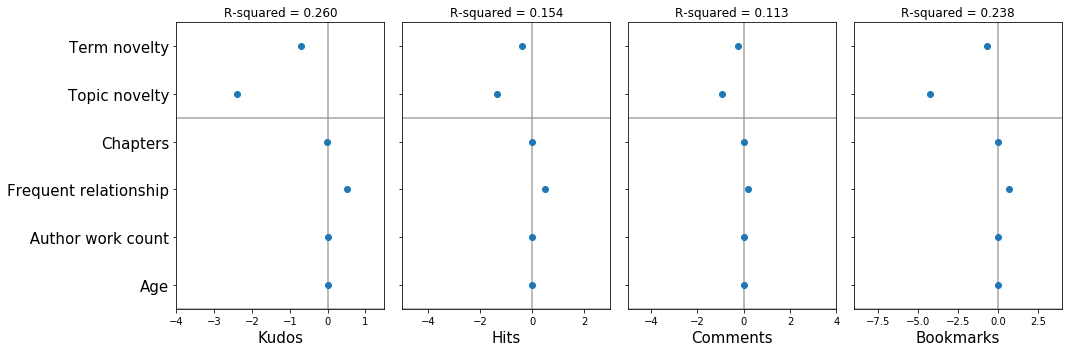

In [14]:
fig, ax = plt.subplots(1,4,figsize = (15,5))
ax[0].errorbar(kudos_coef[::-1], range(len(kudos_coef)), xerr=kudos_err[::-1] , fmt='o')
ax[0].set_yticks(range(len(kudos_coef)))
ax[0].set_yticklabels(ylabels)
ax[0].plot([0 for i in range(len(kudos_coef)+2)], range(-1,len(kudos_coef)+1), c='grey', alpha = 0.7)
ax[0].plot(range(-8,3), [22.5 for i in range(-8,3)] ,c='grey', alpha = 0.7)
ax[0].plot(range(-8,3), [26.5 for i in range(-8,3)] ,c='grey', alpha = 0.7)
ax[0].plot(range(-8,3), [32.5 for i in range(-8,3)] ,c='grey', alpha = 0.7)
ax[0].plot(range(-8,3), [38.5 for i in range(-8,3)] ,c='grey', alpha = 0.7)
ax[0].plot(range(-8,3), [42.5 for i in range(-8,3)] ,c='grey', alpha = 0.7)
ax[0].set_ylim(38.5,44.5)
ax[0].set_xlim(-4,1.5)
ax[0].set_xlabel('Kudos', fontsize=15)
ax[0].set_title('R-squared = 0.260')
for tick in ax[0].yaxis.get_major_ticks():
    tick.label.set_fontsize(15)

ax[1].errorbar(hits_coef[::-1], range(len(hits_err)), xerr=hits_err[::-1], fmt='o')
ax[1].set_yticks(range(len(hits_coef)))
# ax[1].set_yticklabels(ylabels)
ax[1].plot([0 for i in range(len(hits_coef)+2)], range(-1,len(hits_coef)+1), c='grey', alpha = 0.7)
ax[1].plot(range(-8,4), [22.5 for i in range(-8,4)] ,c='grey', alpha = 0.7)
ax[1].plot(range(-8,4), [26.5 for i in range(-8,4)] ,c='grey', alpha = 0.7)
ax[1].plot(range(-8,4), [32.5 for i in range(-8,4)] ,c='grey', alpha = 0.7)
ax[1].plot(range(-8,4), [38.5 for i in range(-8,4)] ,c='grey', alpha = 0.7)
ax[1].plot(range(-8,4), [42.5 for i in range(-8,4)] ,c='grey', alpha = 0.7)
ax[1].set_ylim(38.5,44.5)
ax[1].set_xlim(-5,3)
ax[1].set_yticklabels([])
ax[1].set_title('R-squared = 0.154')
ax[1].set_xlabel('Hits', fontsize=15)

ax[2].errorbar(comments_coef[::-1], range(len(comments_err)), xerr=comments_err[::-1], fmt='o')
ax[2].set_yticks(range(len(comments_coef)))
ax[2].plot([0 for i in range(len(comments_coef)+2)], range(-1,len(comments_coef)+1), c='grey', alpha = 0.7)
ax[2].plot(range(-8,5), [22.5 for i in range(-8,5)] ,c='grey', alpha = 0.7)
ax[2].plot(range(-8,5), [26.5 for i in range(-8,5)] ,c='grey', alpha = 0.7)
ax[2].plot(range(-8,5), [32.5 for i in range(-8,5)] ,c='grey', alpha = 0.7)
ax[2].plot(range(-8,5), [38.5 for i in range(-8,5)] ,c='grey', alpha = 0.7)
ax[2].plot(range(-8,5), [42.5 for i in range(-8,5)] ,c='grey', alpha = 0.7)
ax[2].set_ylim(38.5,44.5)
ax[2].set_xlim(-5,4)
ax[2].set_yticklabels([])
ax[2].set_title('R-squared = 0.113')
ax[2].set_xlabel('Comments', fontsize=15)


ax[3].errorbar(bookmarks_coef[::-1], range(len(bookmarks_err)), xerr=bookmarks_err[::-1], fmt='o')
ax[3].set_yticks(range(len(bookmarks_coef)))
ax[3].plot([0 for i in range(len(bookmarks_coef)+2)], range(-1,len(bookmarks_coef)+1), c='grey', alpha = 0.7)
ax[3].plot(range(-9,5), [22.5 for i in range(-9,5)] ,c='grey', alpha = 0.7)
ax[3].plot(range(-9,5), [26.5 for i in range(-9,5)] ,c='grey', alpha = 0.7)
ax[3].plot(range(-9,5), [32.5 for i in range(-9,5)] ,c='grey', alpha = 0.7)
ax[3].plot(range(-9,5), [38.5 for i in range(-9,5)] ,c='grey', alpha = 0.7)
ax[3].plot(range(-9,5), [42.5 for i in range(-9,5)] ,c='grey', alpha = 0.7)
ax[3].set_ylim(38.5,44.5)
ax[3].set_xlim(-9,4)
ax[3].set_yticklabels([])
ax[3].set_title('R-squared = 0.238')
ax[3].set_xlabel('Bookmarks', fontsize=15)

plt.tight_layout()
plt.savefig('ols_coefs_partial.pdf', format='pdf')

In [19]:
print(kudos_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Kudos   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     4605.
Date:                Thu, 23 Aug 2018   Prob (F-statistic):               0.00
Time:                        11:02:02   Log-Likelihood:            -1.3790e+06
No. Observations:              697934   AIC:                         2.758e+06
Df Residuals:                  697888   BIC:                         2.759e+06
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [16]:
# print(hits_model.summary())

In [17]:
# print(comments_model.summary())

In [18]:
# print(bookmarks_model.summary())